In [1]:
!pip install hypernetx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.4/591.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.4 MB/s eta 0:00:00
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.2.1 which is incompatible.


In [1]:
import pandas as pd
import hypernetx as hnx
import matplotlib.pyplot as plt
import networkx as nx

In [7]:
df = pd.read_csv('symbipredict_2022.csv')

In [8]:
df = df.groupby('prognosis').max()

In [9]:
df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
prognosis,,,,,,,,,,,,,,,,,,,,,
AIDS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acne,0,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
Alcoholic Hepatitis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Allergy,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arthritis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import entropy


symptoms = df.columns[df.columns != 'prognosis'].tolist()
H = df[symptoms].values
num_diseases = H.shape[0]
num_symptoms = H.shape[1]


De = np.sum(H, axis=0)
De[De == 0] = 1
W = np.ones_like(De, dtype=float)
De_inv = np.diag(1.0 / De)
A = np.dot(np.dot(H, np.diag(W)), np.dot(De_inv, H.T))
A = (A + A.T) / 2
A[A < 0] = 0


def compute_logZ(c, H, num_clusters):
    total_entropy = 0.0
    for j in range(H.shape[1]):
        cluster_counts = np.zeros(num_clusters)
        for i in range(H.shape[0]):
            if H[i, j] == 1:
                cluster_counts[c[i] - 1] += 1
        total = np.sum(cluster_counts)
        if total > 0:
            probs = cluster_counts / total
            ent = entropy(probs, base=np.e) if np.sum(probs > 0) > 0 else 0
            total_entropy += ent
    return total_entropy / H.shape[1] if H.shape[1] > 0 else 0


def run_chain(H, number_of_clusters, number_of_steps, beta_0=1.0):
    c = np.random.randint(1, number_of_clusters + 1, size=num_diseases)
    best_entropy = compute_logZ(c, H, number_of_clusters)
    best_cluster = c.copy()
    t = 0

    while t < number_of_steps:
        c_prime = c.copy()
        idx = np.random.randint(0, num_diseases)
        new_cluster = np.random.randint(1, number_of_clusters + 1)
        c_prime[idx] = new_cluster

        logZ_c = compute_logZ(c, H, number_of_clusters)
        logZ_c_prime = compute_logZ(c_prime, H, number_of_clusters)
        delta = logZ_c_prime - logZ_c

        beta_t = beta_0 * (t / number_of_steps + 0.1)
        X = np.random.uniform(0, 1)
        if X < min(1, np.exp(-beta_t * delta)):
            c = c_prime
            if logZ_c_prime < best_entropy:
                best_entropy = logZ_c_prime
                best_cluster = c.copy()

        t += 1

    return best_cluster, best_entropy


number_of_clusters = 5
number_of_steps = 100
beta_0 = 1.0
best_cluster, best_entropy = run_chain(H, number_of_clusters, number_of_steps, beta_0)

cluster_assignments = {i: best_cluster[i] - 1 for i in range(num_diseases)}
num_clusters = len(set(best_cluster))

print("Best Cluster Assignments:", cluster_assignments)
print("Best Entropy:", best_entropy)
print("Number of Clusters:", num_clusters)

Best Cluster Assignments: {0: np.int64(1), 1: np.int64(4), 2: np.int64(4), 3: np.int64(0), 4: np.int64(0), 5: np.int64(3), 6: np.int64(2), 7: np.int64(2), 8: np.int64(3), 9: np.int64(2), 10: np.int64(0), 11: np.int64(0), 12: np.int64(3), 13: np.int64(3), 14: np.int64(1), 15: np.int64(3), 16: np.int64(1), 17: np.int64(4), 18: np.int64(0), 19: np.int64(3), 20: np.int64(4), 21: np.int64(4), 22: np.int64(4), 23: np.int64(2), 24: np.int64(0), 25: np.int64(0), 26: np.int64(0), 27: np.int64(3), 28: np.int64(3), 29: np.int64(2), 30: np.int64(4), 31: np.int64(4), 32: np.int64(0), 33: np.int64(3), 34: np.int64(2), 35: np.int64(0), 36: np.int64(0), 37: np.int64(0), 38: np.int64(2), 39: np.int64(3), 40: np.int64(3)}
Best Entropy: 0.3048142603041112
Number of Clusters: 5


<ipython-input-24-84ef6e85f01e>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_clusters)  # Use tab10 colormap


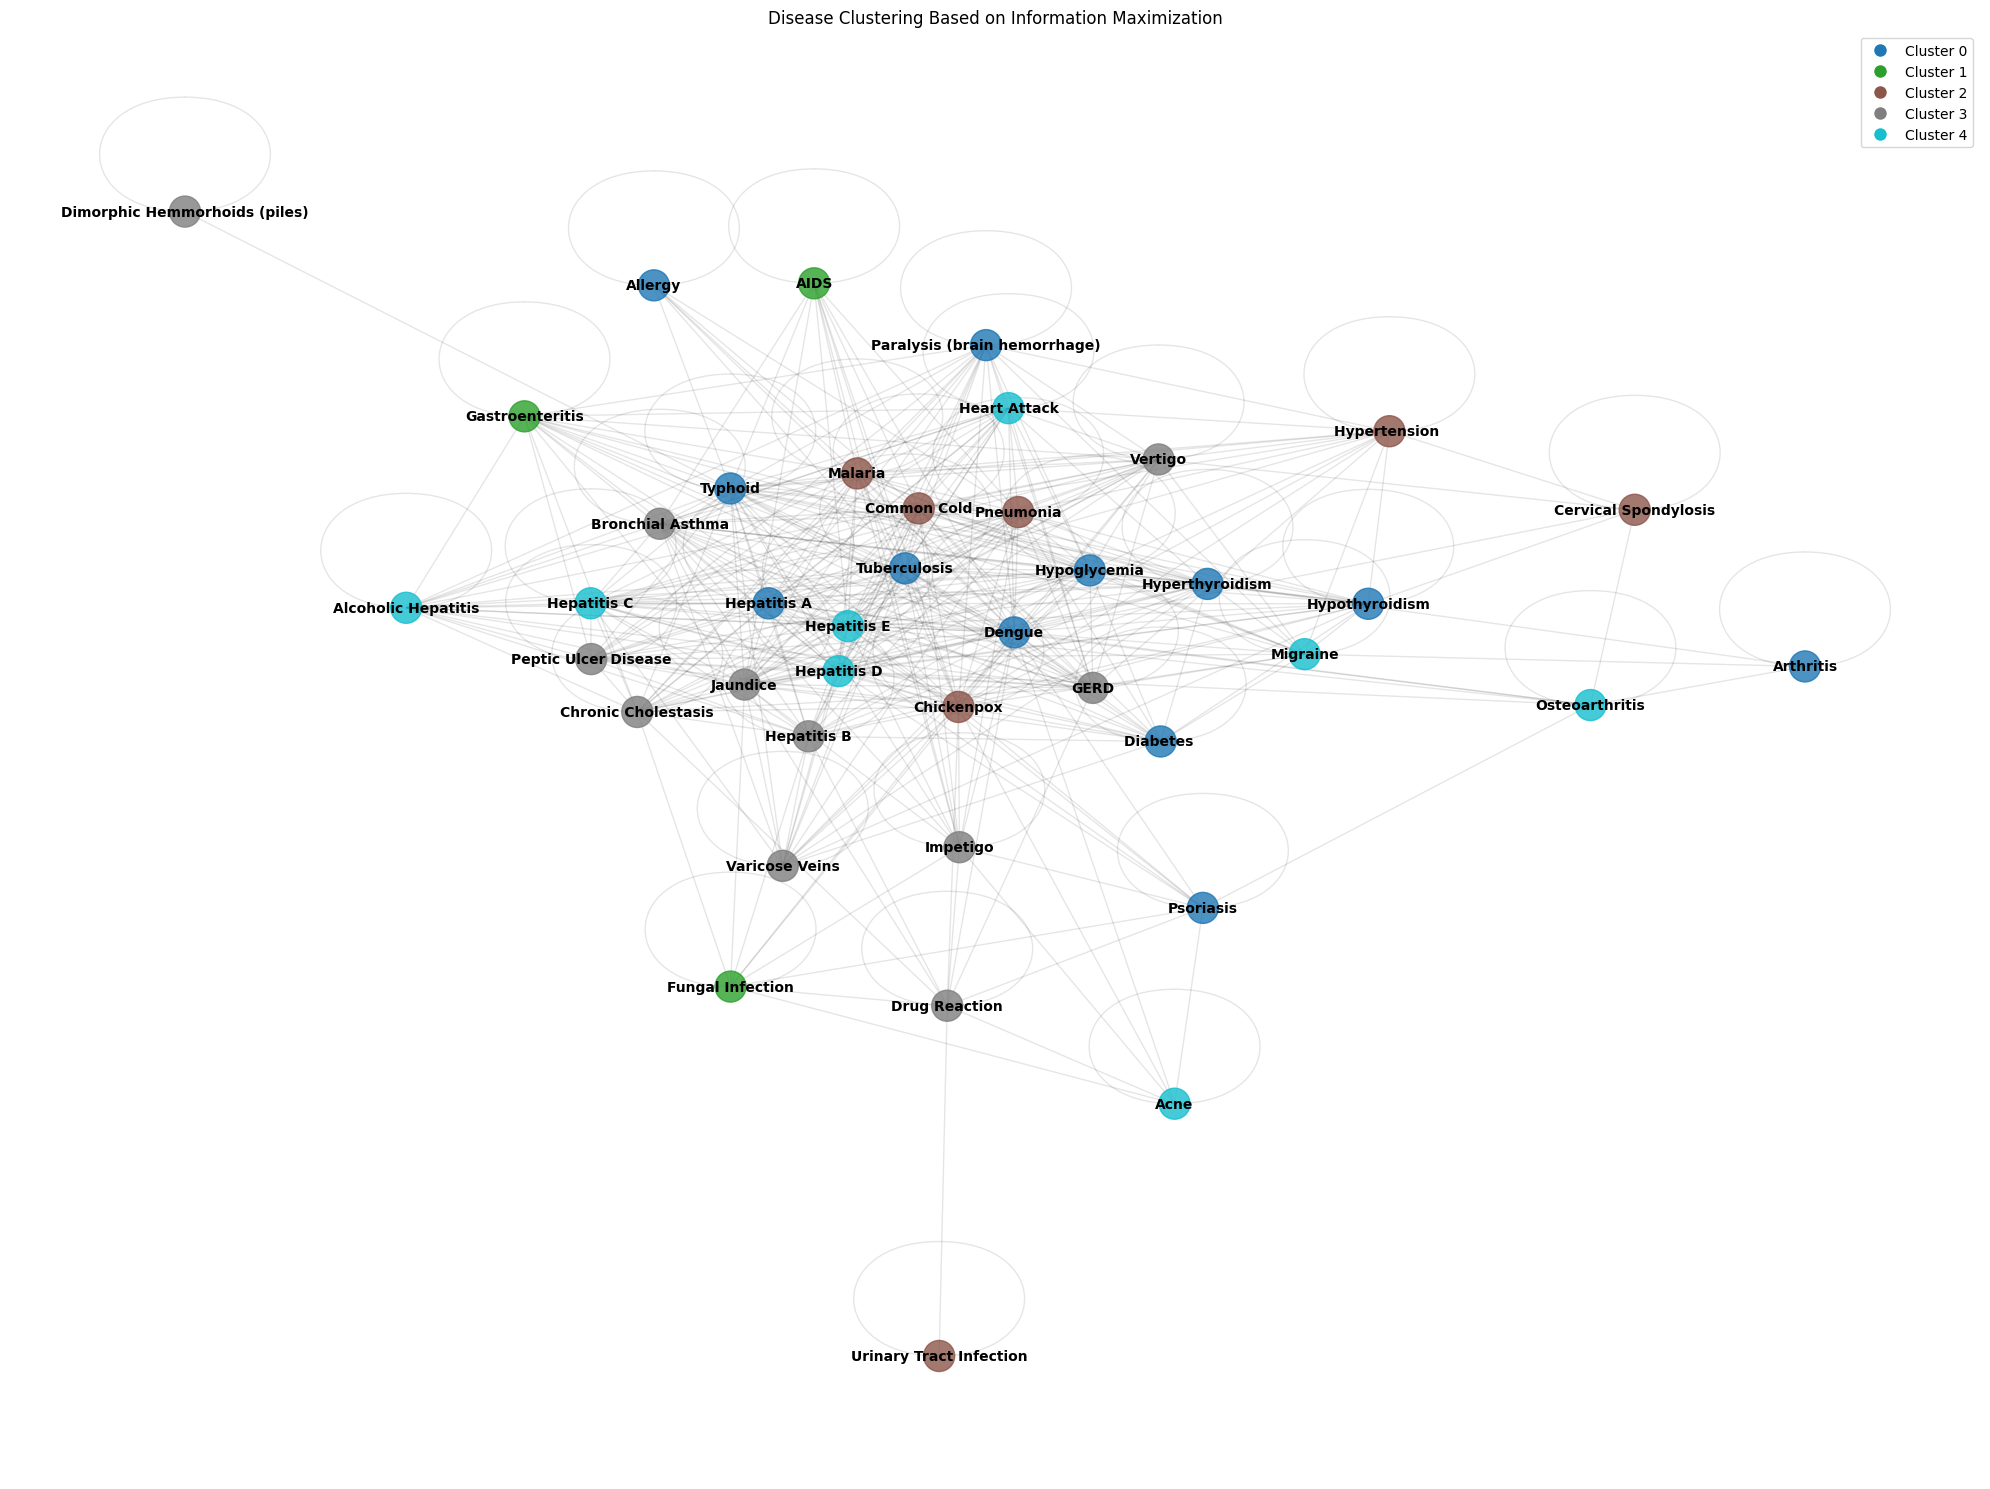

In [24]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
def visualize_clustering(A, cluster_assignments, num_clusters, disease_names):
    G = nx.from_numpy_array(A)
    mapping = {i: name for i, name in enumerate(disease_names)}
    G = nx.relabel_nodes(G, mapping)

    colors = plt.cm.get_cmap('tab10', num_clusters)
    node_colors = [colors(cluster_assignments[i]) for i in range(len(disease_names))]

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(20, 15))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, alpha=0.1)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
               markerfacecolor=colors(i), markersize=10)
        for i in range(num_clusters)
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title("Disease Clustering Based on Information Maximization")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


unique_prognoses = df.index.unique().tolist()
visualize_clustering(A, cluster_assignments, num_clusters, unique_prognoses)

In [25]:
cluster_table = pd.DataFrame({
    'Disease': unique_prognoses,
    'Cluster': [cluster_assignments[i] for i in range(len(df))]
})


cluster_table.to_csv('disease_clusters_information_maximization.csv', index=False)

print(cluster_table)

                          Disease  Cluster
0                            AIDS        1
1                            Acne        4
2             Alcoholic Hepatitis        4
3                         Allergy        0
4                       Arthritis        0
5                Bronchial Asthma        3
6            Cervical Spondylosis        2
7                      Chickenpox        2
8             Chronic Cholestasis        3
9                     Common Cold        2
10                         Dengue        0
11                      Diabetes         0
12  Dimorphic Hemmorhoids (piles)        3
13                  Drug Reaction        3
14               Fungal Infection        1
15                           GERD        3
16                Gastroenteritis        1
17                   Heart Attack        4
18                    Hepatitis A        0
19                    Hepatitis B        3
20                    Hepatitis C        4
21                    Hepatitis D        4
22         

In [28]:
number_of_clusters = 6
number_of_steps = 100
beta_0 = 1.0
best_cluster, best_entropy = run_chain(H, number_of_clusters, number_of_steps, beta_0)

cluster_assignments = {i: best_cluster[i] - 1 for i in range(num_diseases)}
num_clusters = len(set(best_cluster))

print("Best Cluster Assignments:", cluster_assignments)
print("Best Entropy:", best_entropy)
print("Number of Clusters:", num_clusters)

Best Cluster Assignments: {0: np.int64(2), 1: np.int64(4), 2: np.int64(2), 3: np.int64(3), 4: np.int64(4), 5: np.int64(3), 6: np.int64(1), 7: np.int64(5), 8: np.int64(5), 9: np.int64(1), 10: np.int64(5), 11: np.int64(1), 12: np.int64(4), 13: np.int64(2), 14: np.int64(2), 15: np.int64(2), 16: np.int64(5), 17: np.int64(1), 18: np.int64(1), 19: np.int64(1), 20: np.int64(0), 21: np.int64(5), 22: np.int64(0), 23: np.int64(3), 24: np.int64(1), 25: np.int64(5), 26: np.int64(5), 27: np.int64(2), 28: np.int64(0), 29: np.int64(4), 30: np.int64(2), 31: np.int64(5), 32: np.int64(2), 33: np.int64(5), 34: np.int64(1), 35: np.int64(5), 36: np.int64(1), 37: np.int64(4), 38: np.int64(5), 39: np.int64(1), 40: np.int64(5)}
Best Entropy: 0.30806748185118693
Number of Clusters: 6
